# K-means, Spectral Embedding, Eigenvalue computation

In [ ]:
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import networkx as nx
import scipy as sp


# Preamble: Functions definition 
You can put here your main functions. But feel free to move them somewhere else in the code at your convenience.

In [ ]:
def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

# Section1: where we work out a simple synthetic dataset

## **Task1.** Create a concentric-discs dataset.   
- Each datapoint should be a two-dimensional vector of x,y coordinates (i.e. we are considering the very simple case of data with only two features)  
- The number of discs is identified by a list of radii  
- Each disc should contain a number of points identified by a list of integers 
- The coordinates of the points should be perturbed with a white noise of magnitude "noiselevel"

### Create disc function

In [ ]:
def create_disc_data(num_points_per_class, r, noiselevel=0.5):
  
  # first case
  index=0
  circ = np.linspace(0,2*np.pi,num_points_per_class[index])                                 # points between 0 and 2 pi for class 0
  x = r[index]*np.cos(circ) + np.random.normal(0,noiselevel,num_points_per_class[index])    # apply cos and noise
  y = r[index]*np.sin(circ) + np.random.normal(0,noiselevel,num_points_per_class[index])    # apply sen and noise
  output = np.stack((x,y),axis=1)

  # following case in which i stack
  for index in range(1,len(r)):
     circ = np.linspace(0,2*np.pi,num_points_per_class[index])                              # points between 0 and 2 pi for class i
     x = r[index]*np.cos(circ) + np.random.normal(0,noiselevel,num_points_per_class[index]) # apply cos and noise
     y = r[index]*np.sin(circ) + np.random.normal(0,noiselevel,num_points_per_class[index]) # apply sin and noise
     points = np.stack((x,y),axis=1)
     output = np.concatenate((output,points))

  return output

### Create dataset

 Using $create\_disc\_data$ I generate points between 0 and 2$\pi$ using $linspace$ and then applying $cos$ and $sin$ (and noise) I get the dataset.

In [ ]:
points_per_class = [100, 100, 100]         # points per class
r = [2,5,8]                                # radius
n = sum(points_per_class)                  # dataset size
X = create_disc_data(points_per_class, r)  # dataset

Plot the data with differents noises

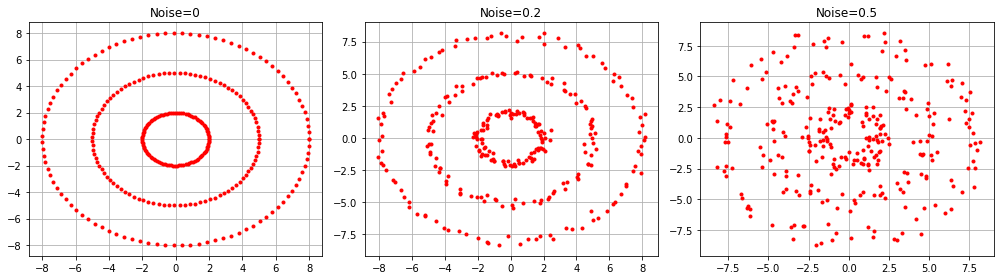

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14,4))
# Noise = 0
X = create_disc_data(points_per_class, r,noiselevel=0)
axs[0].plot(X[:,0], X[:,1], color='r', ls='', marker='.', label='Data points')
axs[0].set_title('Noise=0')
# Noise = 0.2
X = create_disc_data(points_per_class, r,noiselevel=0.2)
axs[1].plot(X[:,0], X[:,1], color='r', ls='', marker='.', label='Data points')
axs[1].set_title('Noise=0.2')
# Noise = 0.5
X = create_disc_data(points_per_class, r,noiselevel=0.5)
axs[2].plot(X[:,0], X[:,1], color='r', ls='', marker='.', label='Data points')
axs[2].set_title('Noise=0.5')

[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

## **Task2.** Design a k-means function and assign clusters to the initial dataset embedding using kmeans 

Define a function that implements k-means.  
Recall that k-means loss function is $f(X, c) = \sum_{i = 1}^K \sum_{j|X_j \in c_i} \|X_j - c_i\|$

### Function definition

In [ ]:
def index_closest_centroid(x,centroids):
   # Input: single data, centroids
   # Output: return index of nearest centroids 
   
   index = np.argmin(np.linalg.norm(x-centroids,axis=1))
   return index

In [ ]:
def compute_classes(X,centroids):
   # Input: dataset, centroids
   # Output: index list of nearest centroids for each data 
   
   index = np.array([])
   for x in X:
     index = np.append(index,index_closest_centroid(x,centroids))
   return index

In [ ]:
def k_means_loss(X,index,centroids):
   # Input: dataset, index list of nearest centroids, centroids
   # Output: k-means loss function
   
   list_centroids = [centroids[int(i)] for i in index]  # list with indexes of class for each element in X
   loss = sum(np.linalg.norm(X-list_centroids,axis=1))  # k-means loss function
   return loss

In [ ]:
def compute_centroids(X,index,k):
  # Input: dataset, index list of nearest centroids, number of classes
  # Output: centroid of each classes

  centroids = np.zeros([k,np.shape(X)[1]])
  for i in range(k):
    class_position = np.where(index==i)   # positions of point in a class
    # sum of coordinates in each class / number of element in the class
    centroids[i,:]=((np.sum(X[class_position],axis=0))/np.shape(class_position)[1])
  return centroids

In [ ]:
def k_means_one_run(X, centroids, maxit = 30):
  # Input: dataset, centroids, maximum number of iterations
  # Output: loss list, centroid movement, final centroids

  loss_vec = []
  centr_list = []
  k = len(centroids)

  for i in range(maxit):
    index = compute_classes(X,centroids)     # return class for all data
    loss = k_means_loss(X,index,centroids)   # compute loss
    loss_vec.append(loss)                    # loss list
    centr_list.append(centroids)             # centroids position list
    centroids = compute_centroids(X,index,k) # centroids 

  # calculate centroids movement
  c_dist = np.sum(np.linalg.norm(centr_list-centroids,axis=2),axis=1) 

  return loss_vec, c_dist, centroids

In [ ]:
def k_means_full(X, k, restarts = 5):
  # Input: dataset, number of classes
  # Output: best k means performance

  final_loss_vec = [10**6]
  for i in range(restarts):                                        
      starting_centroids = select_k_points_from(k,X)                        # Select k points at random 
      loss_vec, c_dist, centroids = k_means_one_run(X, starting_centroids)  # k means one run 
      if loss_vec[-1] < final_loss_vec[-1]:                                 # check if loss is improved
        final_loss_vec = loss_vec                                           # update loss
        final_c_dist = c_dist                                               # update c dist
        final_centroids = centroids                                         # update centroids
  return final_loss_vec, final_c_dist, final_centroids

In [ ]:
def select_k_points_from(k,X):
  # Input: number of points that i want, dataset
  # Output: position of random point

  position = np.random.randint(0,len(X),k)
  points = X[position,:]
  return points

### Plot results

$k\_means\_full$ restarts five times $k\_means\_one\_run$ in which are selected every time k=3 centroids at random from X. Then, comparing the final values of the loss function, the code returns the best:

1.   $loss\_vec$, vector of losses at each iteration
2.   $c\_dist$, vector of movements of centroids at each iteration
3.   $centroids$, final positions of centroids




In [ ]:
k = 3     # Number of classes we know the data is made of 
loss_vec, c_dist, centroids = k_means_full(X,k)

Plot loss function and centroid distance function histories

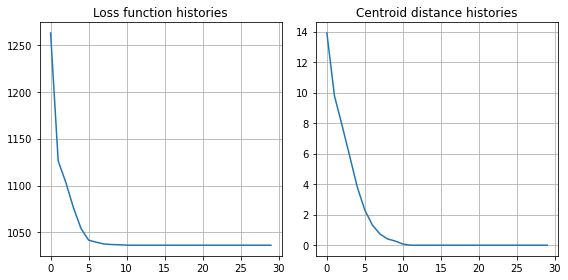

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].plot(loss_vec)
axs[0].set_title('Loss function histories')
axs[1].plot(c_dist)
axs[1].set_title('Centroid distance histories')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

As we can see from the graphs the loss function after 10 iterations remain stack at more than 1000 and centroids stop to move.

Now I plot the obtained classes, as I know from the theory I don't expect to achieve good results.

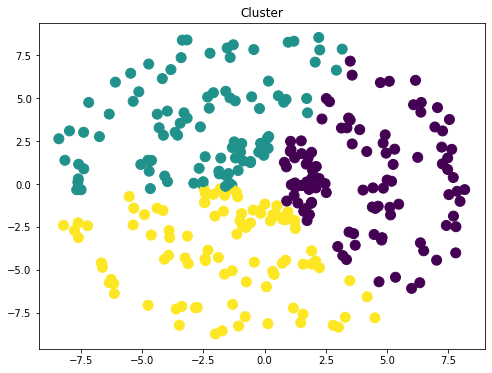

In [ ]:
index = compute_classes(X,centroids)
data = pd.DataFrame({'x1': X[:,0], 'x2': X[:,1], 'y': index})
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X[:,0], X[:,1], c=index, s=100, marker='o')
ax.set_title('Cluster')
fig.show()

## **Task3.** Design a function that creates the knn adjacency matrix of a dataset X

Define a function `adjacency_knn_matrix` that given datapoints $X$ and number $k$ of nearest neighbors returns the adjacency matrix of the similarity graph obtained by either 
- setting $A_{ij}=1$ if $X_j$ is one of the knn of $X_i$, or (`mode="binary"`)
- setting $A_{ij} = \exp(-\|X_i-X_j\|^2/4)$ if $X_j$ is one of the knn of $X_i$  (`mode="distance"`)

### Adjacency knn matrix function

I create Adjacency knn matrix function, the output is the poinwise maximum between $A$ and $A^t$ in order to have a symmetric matrix.

In [ ]:
def adjacency_knn_matrix(X, kn, mode="binary"):
  # Input:
  # X = datapoints
  # kn = number of k-nearest-neighbors
  # mode = specify wether we want a binary matrix or we want to use the distance in the weights via exp(-|xi-xj|)
  
  # Initialization of matrix A and count
  A = np.zeros([len(X),len(X)])
  i=0

  for x in X:
    dist = np.linalg.norm((X-x),axis=1)  # vector of distances between x and other elements in X
    index = np.argpartition(dist, kn+1)  # index of kn+1 smallest elements (kn+1 because one index is the node itself)
    if mode == "binary":
      A[i,index[0:kn+1]]=1

    if mode == "distance":
      A[i,index[0:kn+1]]=np.exp((-dist[index[0:kn+1]]**2)/4)

    i = i+1 
  # I need to subtract identity because in the diagonal I have all 1 (each node is its nearest kneighbour)
  A = A - np.identity(len(X))
  return np.maximum(A, np.transpose(A))     

### Create adjacency knn matrix

In [ ]:
noiselevel=0.3
X = create_disc_data(points_per_class, r, noiselevel) #create data 
knn = 8 # number of nearest neightbour
A = adjacency_knn_matrix(X,knn,mode="distance") # adjacency matrix

## **Task4.** Design a function that draws the graph given the adjacency matrix and the coordinate points X


Define a function `graphdraw` that will allow us to plot a graph. You can use native libraries from Matlab, Python and Julia. The important thing is to be sure to be able to plot forcing the coordinates of the nodes, when available.
You are allowed to use built-in graph drawing functions such `networkx` library in python 

### Graph draw function

In [ ]:
def graphdraw(A,X=[]):
    # Input:
    # A = Adjacency matrix
    # X = coordinates of the nodes (for us, the coordinates of the datapoints)
    # if no coordinates are available, use a spring visualization methods 
    G = nx.from_numpy_matrix(A)
    if len(X)==0:
      nx.draw(G, node_size=10)
    else:
      nx.draw(G,X, node_size=10)


### Plot the graph

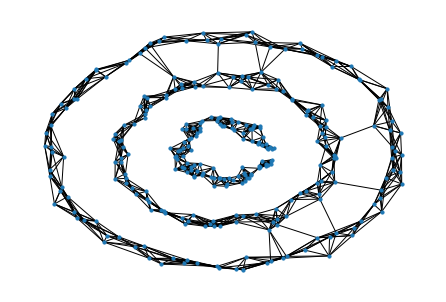

In [ ]:
graphdraw(A,X)

### Normalized Laplacian

Generate the normalized Laplacian matrix from the adjacency matrix
$$ L = I- D^{-1/2}AD^{-1/2}$$

In [ ]:
def normalized_Laplacian(A):
  # Input: adjacency matrix
  # Output: Laplacian matrix
  
  #  for each row i calcolate element greater than 0 (this is the number of connections
  d = np.array([sum(riga) for riga in A]) 
  invroot_D = np.diag(d**(-1/2)) # matrix D^(-1/2)
  normal_L = np.identity(len(d))-np.matmul(invroot_D,np.matmul(A,invroot_D))
  return normal_L

In [ ]:
L = normalized_Laplacian(A)

## **Task5.** Design a function that computes the first m eigevalues/vectors of $L$ using the power method and the deflation idea... 

We now want to compute the first m eigenvectors of the normalized Laplacin using the power method. This method typically computes the eigenvectors for the last m eigenvalues/vectros, so we need to modify $L$ into $M = 2I-L$. Then, each time we compute one eigenvector we need to `deflate` the matrix obtained and we want to still maintain the same computational cost. 

Orthonormalization procedure works like this: 
- Basis of orthonormal vectors $U = [u_1, \dots, u_m]$
- input vector $v$
- Project $v$ onto the basis $U$: $z = UU^Tv$
- orthogonalize: $v - z$
- normalize: $new_v = v/\|v\|$

### Function definition

In [ ]:
def power_method(Mf,n,A, tol=1e-8,maxit=1000):
    # Input:
    # Mf is a function that performs the product M x vector in an efficient way
    # n is the size of the matrix M which is part of the function Mf
    # A matrix
    # tol and maxit are the tolerance for stopping the iterations and the maximum number of iterations we can implement
    # Output: eigenvalue and eigenvector

    # Initialization
    count = 0
    error = 1
    x = np.random.rand(n)
    mu_new = 0

    while count < maxit and error > tol:
      mu_old = mu_new
      y = Mf(A,x)                     # y = A x
      x = y/np.linalg.norm(y)         # normalize 
      mu_new = np.dot(np.dot(x,A),x)  # mu = x^t A x
      error = abs(mu_new-mu_old)      # absolute value between two consecutive mu
      count = count+1                 # update count

    return mu_new, x

def f(A,x):
    # Compute moltiplication between matrix and vector
    b = np.dot(A,x)
    return b

def deflate(Mf, λ, v):
    # given a function that implements the product M x vector, returns a new function that implements the new matrix vector product:
    # (M-λv*v') x vector 
    def new_Mf(A,x):
      return Mf(A-λ*np.outer(v,v),x)
    return new_Mf

def orthonormalize(v, orthonormal_vector_basis):
    # orthonormalizes the vector v w.r.t. a basis of orthonormal vectors
    # if orthonormal_vector_basis = [] returns v/||v||
    if  np.shape(orthonormal_vector_basis)[0]==0:
      return v/np.linalg.norm(v)
    UUt = np.matmul(orthonormal_vector_basis,orthonormal_vector_basis.transpose()) # UU^t
    z = np.dot(UUt,v)                       # z = UU^t v
    new_v = (v-z)/np.linalg.norm(v-z)       # normalize
    return new_v
    
def first_m_eigvectors_power_method(Mf, m, n, A):
  # Input: 
  # Mf function that perform matrix moltiplication
  # m number of eigenvector
  # n dimension of the dataset
  # A matrix

  # Initialization
  eigspace = np.zeros([n,m])
  eigenvalues = []
  function = f

  for i in range(m):
    (λ, v) = power_method(function,n,A) # eigenvalue and eigenvector
    v = orthonormalize(v,eigspace)      # orthonormalize
    eigspace[:,i] = v                   # append eigenvector
    eigenvalues.append(λ)               # append eigenvalue
    function = deflate(function,λ,v)    # update function that perform matrix moltiplication
  return eigenvalues, eigspace
    

### Power method

Since we want to compute the first $m$ eigenvectors I modify $L$ into $M = 2I-L$ and then compute the first $m=3$ eigenvalues and eigenvectors using power method.

In [ ]:
m = 3    # number of eigenvector
n = 300  # dimension of the dataset
M = 2*np.identity(n)-L

# Compute eigenvalues and eigenspace
eigenvalues, eigenspace = first_m_eigvectors_power_method(f, m, n, M)

Now I plot second and third column of the matrix of eigenvectors. To achieve good results we should see separated clusters of points.

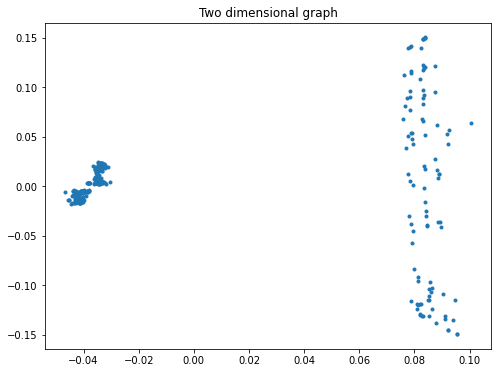

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
newX = eigenspace[:,0:3]
ax.plot(newX[:,1],newX[:,2],  marker='.',  linestyle="")
ax.set_title('Two dimensional graph')
fig.show()

### Cluster using your k-means function on the new embedding given by the computed eigenvectors

In [ ]:
# Apply k-means to the new dataset embedding 
loss_vec, c_dist, centroids = k_means_full(newX,k)

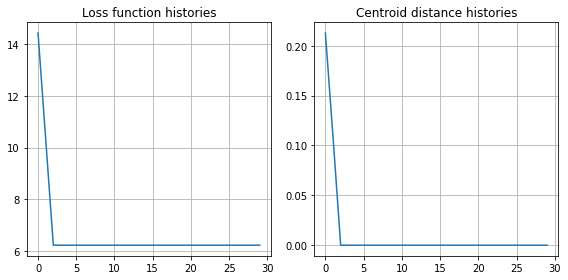

In [ ]:
# Plot the two loss functions 
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].plot(loss_vec)
axs[0].set_title('Loss function histories')
axs[1].plot(c_dist)
axs[1].set_title('Centroid distance histories')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

In this case the value of loss function is much lower respect the one in $task \ 2$, we are about 10, two orders of magnitude less. In this case the algorith stop to move centroids after only about 5 iterations. 

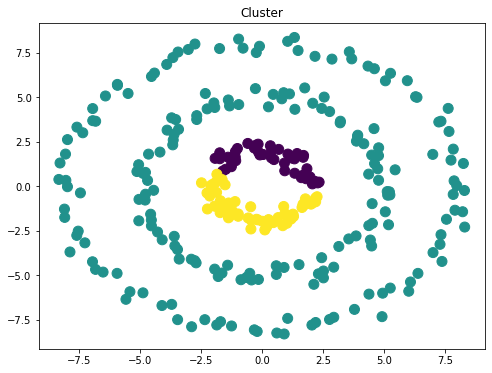

In [ ]:
# plot the new class assignment
index = compute_classes(newX,centroids)
data = pd.DataFrame({'x1': X[:,0], 'x2': X[:,1], 'y': index})
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(X[:,0], X[:,1], c=index, s=100, marker='o')
ax.set_title('Cluster')
fig.show()

The power method, unlike k-means, is able to divide correctly the three classes.

## **Task6.** In order to quantify the quality of the resulting clustering assignment, evaluate design functions that compute accuracy, precision and recall

Accuracy: 
Compute the ratio (number of correctly assigned points) / (total number of points). 

Precision: 
Per each class compute the ratio (number of correctly assigned points to that class) / (total number of points that I predicted were in that class). Then, take the mean over the precision of the classes.   
It can be summarized with the slogan:
True Positves / (True Positives + False Positives)

Recall: 
Per each class compute the ratio (number of correctly assigned points to that class) / (total number of points that really are in the class). Then, take the mean over the recall of the classes.   
It can be summarized with the slogan:
True Positves / (True Positives + False Negatives)


For how I define the dataset each 100 data we have a class. Thus to calculate the true labels is sufficient to concatenate these three vectors.

In [ ]:
# Compute true labels
true_index = np.concatenate((np.array([0]*100),np.array([1]*100),np.array([2]*100)))

Now I compute the confusion matrix. By definition a confusion matrix $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ and predicted to be in $j$ group .

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(true_index, index)
# Show the confusion matrix
pd.DataFrame(cm)

,0,1,2
0,44,0,56
1,0,100,0
2,0,100,0


Here the problem is that power method is dividing my data in $m$ classes but i don't know their order (e.g. I don't know if first class is the one with radius 2 or 5 or 9) and this does not permit to calculate accuracy, precision and recall. \\
Thus i decided to modify the indexes of the classes in order to maximize the accuracy. To do that i create the function *order* that rearrange the confusion matrix maximizing elements in the diagonal.

### Function definition

In [ ]:
def order(cm):
 matrix = np.copy(cm)    # copy of confusion matrix
 for i in range(len(cm)):
  index_maximum = list(np.where(matrix == np.amax(matrix)))  # find index of maximum element 
  if len(index_maximum[0])>1:                                # case in which maximum are more than one
      index_maximum[0]=index_maximum[0][0]                   # take only the first
      index_maximum[1]=index_maximum[1][0]
  if index_maximum[0] != index_maximum[1]:                   # if maximum if not in the diagonal I move the column
    cm[:,[index_maximum[0],index_maximum[1] ]] = cm[:,[index_maximum[1], index_maximum[0]]]          # now maximum is in the diagonal
    matrix[:,[index_maximum[0],index_maximum[1] ]] = matrix[:,[index_maximum[1], index_maximum[0]]]  # I do the same in matrix
  matrix[index_maximum[0],:]=np.zeros(len(matrix))                                                   # put to zero the row of maximum in order to not find it in next iterations
  matrix[:,index_maximum[0]]=np.zeros_like(matrix[:,index_maximum[1]])                               # put to zero the column of maximum in order to not find it in next iterations

In [ ]:
order(cm)
# Show the confusion matrix
pd.DataFrame(cm)

,0,1,2
0,56,0,44
1,0,100,0
2,0,100,0


### Compute accuracy precision and recall

Once we have corrected confusion matrix obtaining accuracy, precision and recall is easy. \\
Accuracy is the sum of element in the diagonal divided by the total number of points. \\
Precision is the element in the diagonal divided by the sum of elements in its column. \\
Recall is the element in the diagonal divided by the sum of elements in its row.

In [ ]:
def validation_metrics(confusion_matrix):
  # Input: confusion matrix
  # Output: compute accuracy, precision, recall
  
  accuracy=sum(np.diag(confusion_matrix))/np.sum(confusion_matrix)

  precision = []
  for i in range(len(confusion_matrix)):
    precision.append(confusion_matrix[i,i]/(sum(confusion_matrix[:,i])))

  recall = []
  for i in range(len(confusion_matrix)):
    recall.append(confusion_matrix[i,i]/(sum(confusion_matrix[i,:])))
  
  return accuracy, np.mean(precision), np.mean(recall)

In [ ]:
# Compute the accuracy of the class assignment
acc,prec,rec = validation_metrics(cm)

-----

## **Task7.** (Optional)  Change the parameters generating 

---

On top of computing the validation metrics for this particular setting, it would be nice to have a validation across different rages of the parameters. For example, you could run again the method for different values of knn, different number of points in the classes, different radii for the circles and observe that things do not work all the time (or they work very differently all the time) 

### Validation function

In order to have a more compact code i write a function that returns validation metrics comprising all previous codes. It depends only by knn, number of points in the classes, radii of the circles and noise.

In [ ]:
def compute_validation(knn,points_per_class,r,noiselevel):
  X = create_disc_data(points_per_class, r,noiselevel) #create data 
  A = adjacency_knn_matrix(X,knn, mode="distance") # adjacency matrix
  L = normalized_Laplacian(A)
  n = np.shape(X)[0] # Number of points in the dataset
  m = 3 # number of eigenvector
  M = 2*np.identity(n)-L
  eigenvalues, eigenspace = first_m_eigvectors_power_method(f, m, n, M) # Compute eigenvalues and eigenspace
  newX = eigenspace[:,0:3]
  k = 3
  loss_vec, c_dist, centroids = k_means_full(newX, k) # Apply k-means to the new dataset embedding

  # plot the new class assignment
  index = compute_classes(newX,centroids)
  data = pd.DataFrame({'x1': X[:,0], 'x2': X[:,1], 'y': index})
  fig, ax = plt.subplots(figsize=(4,3))
  ax.scatter(X[:,0], X[:,1], c=index, s=100, marker='o')
  ax.set_title('Cluster')
  fig.show()

  true_index = np.concatenate((np.array([0]*points_per_class[0]),np.array([1]*points_per_class[1]),np.array([2]*points_per_class[2])))
  cm = metrics.confusion_matrix(true_index, index)
  order(cm) 

  # Compute the accuracy of the class assignment
  acc,prec,rec = validation_metrics(cm)

  return acc,prec,rec


### Change knn

Let's start changing the number of nearest neighbors and keeping fix other quantities.










In [ ]:
points_per_class = [100,100,100]
r = [2,5,8]
noiselevel = 0.3

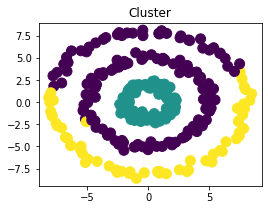

In [ ]:
knn = 10  # number of nearest neightbour
acc,prec,rec = compute_validation(knn,points_per_class,r,noiselevel)

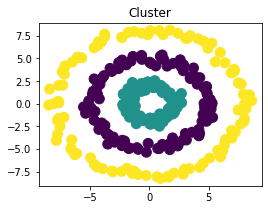

In [ ]:
knn = 9  # number of nearest neightbour
acc,prec,rec = compute_validation(knn,points_per_class,r,noiselevel)

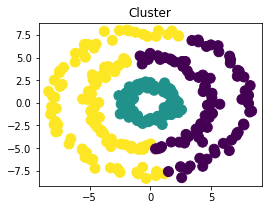

In [ ]:
knn = 8  # number of nearest neightbour
acc,prec,rec = compute_validation(knn,points_per_class,r,noiselevel)

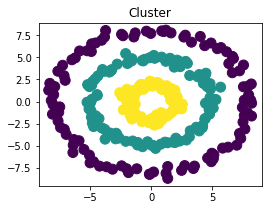

In [ ]:
knn = 7  # number of nearest neightbour
acc,prec,rec = compute_validation(knn,points_per_class,r,noiselevel)

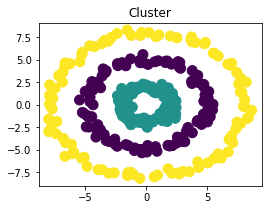

In [ ]:
knn = 6  # number of nearest neightbour
acc,prec,rec = compute_validation(knn,points_per_class,r,noiselevel)

With a noise of 0.3 the code works better with less nearest neighbours, this comes from the fact that using a big $knn$ there are a lot of edges between circles of different radius which can compromise the efficiency. \\
To notice that all points in the internal circle are usually corrected assigned, this can comes from the fact that they are very near respect the others.

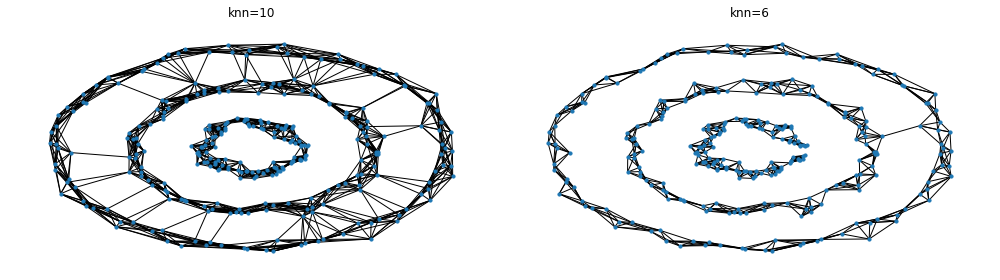

In [ ]:
# Compute graph in the case knn=10 and knn=6
fig, axs = plt.subplots(1, 2, figsize=(14,4))

knn = 10
A = adjacency_knn_matrix(X,knn, mode="distance") # adjacency matrix
G = nx.from_numpy_matrix(A)
nx.draw(G,[(x,y) for x,y in X], node_size=10, ax=axs[0])
axs[0].set_title('knn=10')

knn = 6
A = adjacency_knn_matrix(X,knn, mode="distance") # adjacency matrix
G = nx.from_numpy_matrix(A)
nx.draw(G,[(x,y) for x,y in X], node_size=10, ax=axs[1])
axs[1].set_title('knn=6')

plt.tight_layout()
plt.show()

### Change radii

Now change values of radii

In [ ]:
points_per_class = [100,100,100]
noiselevel = 0.1
knn = 8  # number of nearest neightbour

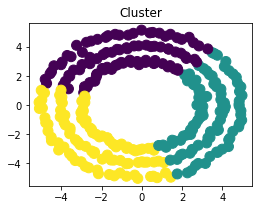

In [ ]:
r = [3,4,5]
acc,prec,rec = compute_validation(knn,points_per_class,r,noiselevel)

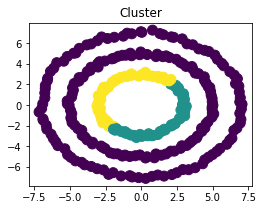

In [ ]:
r = [3,5,7]
acc,prec,rec = compute_validation(knn,points_per_class,r,noiselevel)

Reducing difference between radii the code in not able to divide properly data.

### Change points per class

Now we change points per class

In [ ]:
r = [2,5,8]
noiselevel = 0.2
knn = 8  

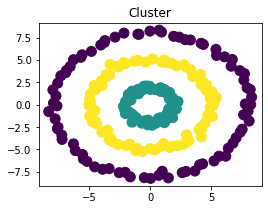

In [ ]:
points_per_class = [80,80,80]
acc,prec,rec = compute_validation(knn,points_per_class,r,noiselevel)

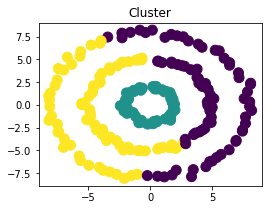

In [ ]:
points_per_class = [50,80,80]
acc,prec,rec = compute_validation(knn,points_per_class,r,noiselevel)

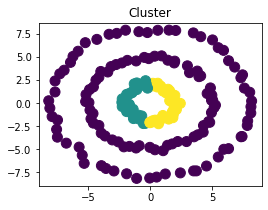

In [ ]:
points_per_class = [80,60,60]
acc,prec,rec = compute_validation(knn,points_per_class,r,noiselevel)

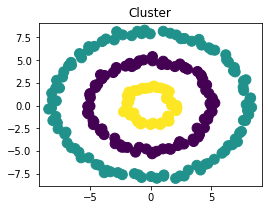

In [ ]:
points_per_class = [40,80,100]
acc,prec,rec = compute_validation(knn,points_per_class,r,noiselevel)

I see that to cluster data, the code needs more data in external circle while there is no difference if we use less point in internal one.

-------

## **Task8.**  Design a function that computes the m smallest eigenvalues of the normalized Laplacian using Krylov approach 
Use free book of Y Saad `Numerical methods for large eigenvalue problems` and our lecture notes to define the function that computes the first m eigenvectors of L using Krylov

Note that internally you will need to compute the eigenvalues/vectors of the matrices $H_m$. These matrices are small and full (not sparse!). You can use built-in full matrix eigensolvers for this: 
- `eig` in Matlab 
- `eigvectors` in Julia
- `numpy.linalg.eig` in python

### Basic Krylov approach

In [ ]:
def first_m_eigvectors_krylov(L, m):
  # Input: matrix and number of eigenvector that we want
  # Output: krilov_eigenvalues, krilov_eigenspace
  
  # Initialization
  u = np.random.rand(len(L))   # random vector
  u = u/np.linalg.norm(u)      # normalize
  U = u                        # create vector space U
  H = np.zeros([len(L),m])     # initialize H

  for i in range(m):
    w = np.dot(L,u)                    # w = L u
    h = np.matmul(U.transpose(),w)     # h = U^t w
    u = w - np.dot(U,h)                # orthonormalize
    H[0:i+1,i] = h                     # update H
    H[i+1,i] = np.linalg.norm(u)  
    if H[i+1,i]< 10**(-6):             # check if error is less than toll 
      krilov_eigenvalues, small_krilov_eigenspace = np.linalg.eig(H[0:i,0:i])
      krilov_eigenspace = np.dot(U[:,0:i],small_krilov_eigenspace)
      return krilov_eigenvalues, krilov_eigenspace

    u = u/H[i+1,i]                     # normalize
    U = np.c_[U, u]                    # update U

  # compute eigenvalues and eigenvectors of matrix H
  krilov_eigenvalues, small_krilov_eigenspace = np.linalg.eig(H[0:m,0:m]) 
  krilov_eigenspace = np.dot(U[:,0:m],small_krilov_eigenspace) # eigenvectors of matrix L
  return krilov_eigenvalues, krilov_eigenspace

### Restarted Krylov approach

I notice that using basic Krylov approach I was not able to get proper eigenvectors and eigenvalues. \\
Thus, I implement the restarted Krylov method, if $H_{m+1,m}$ is over a tollerance the algorith restarts using as initial vector the weighted sum of all approximate eigenvectors. As written in `Numerical methods for large eigenvalue problems` of Y Saad, there is no easy way of choosing weights of the eigenvectors in a systematic manner, so I decide to use all coefficients equal to 1.  The result however is that for hard problems,convergence is difficult to achieve. 

In [ ]:
def krylov_methods(L,U,u,m):
  # Input: matrix, eigenvector space with only u, initial vector, number of eigenvector that we want
  # Output: matrix H and U
  
  H = np.zeros([m+1,m]) 
  for i in range(m):
       w = np.dot(L,u)                    # w = L u
       h = np.matmul(U.transpose(),w)     # h = U^t w
       u = w - np.dot(U,h)                # orthonormalize
       H[0:i+1,i] = h                     # update H
       H[i+1,i] = np.linalg.norm(u)       
       u = u/H[i+1,i]                     # normalize
       U = np.c_[U, u]                    # update U
  return H, U 

In [ ]:
def first_m_eigvectors_krylov(L, m):
  # Input: matrix and number of eigenvector that we want
  # Output: krilov_eigenvalues, krilov_eigenspace
  
  # Initialization
  u = np.random.rand(len(L))   # random vector
  u = u/np.linalg.norm(u)      # normalize
  count = 0                    # count
  H = np.zeros([m+1,m])        # H
  H[m,m-1] = 1                 # needed to enter in the while

  while H[m,m-1]>0.01 and count<1000:
    U = u                                # create vector space U
    H, U = krylov_methods(L,U,u,m)  
    # compute eigenvalues and eigenvectors of matrix H     
    krilov_eigenvalues, small_krilov_eigenspace = np.linalg.eigh(H[0:m,0:m])
    # For restart
    Y = np.dot(U[:,0:m],small_krilov_eigenspace)  # eigenvectors of matrix L
    u = np.sum(Y,axis=1)                          # sum of all approximate eigenvectors
    u = u/np.linalg.norm(u)                       # normalize
    count = count + 1          

  krilov_eigenspace = Y         
  return krilov_eigenvalues, krilov_eigenspace

-----

## **Task9.** (Optional) Compare the eigenvectors computed across different methods (including native eigensolver).
This more "open ended" task requires to make comparisons between the eigenvectors you computed with power method, those computed with your Krylov function and those computed with the native functions below. You should think of a way to compare the eigenvalues.
- Matlab -- `eigs`
- Python -- `scipy.sparse.linalg.eigs`
- Julia -- `Arpack.eigs`

In [ ]:
points_per_class=[100,100,100]
r = [2,5,8]
noiselevel = 0.2

In [ ]:
X = create_disc_data(points_per_class, r,noiselevel) #create data 
A = adjacency_knn_matrix(X,knn, mode="binary") # adjacency matrix
L = normalized_Laplacian(A)
m = 5 # number of eigenvector
n = 300  # dimension of the dataset
M = 2*np.identity(n)-L

### Power method

In [ ]:
power_eigenvalues, power_eigenspace = first_m_eigvectors_power_method(f, m, n, M)

### Krylov method

Using Krylov method instead of calculate first $m$ eigenvectors and eigenvalues I use a space of dimension $3m$

In [ ]:
n = 3*m
krilov_eigenvalues, krilov_eigenspace = first_m_eigvectors_krylov(M,n)

### Build-in method

In [ ]:
eigenvalues, eigenspace = np.linalg.eigh(M)

### Eigenvalues comparison

To compare first five eigenvalues computed with build-in method and power method i just take the maximum difference. \\
Results are quite good.

In [ ]:
max_diff = np.max(np.abs(eigenvalues[::-1][0:5]-power_eigenvalues))
print('The L-infinity difference between first five eigenvalues compute with build-in method and power method is', max_diff)

The L-infinity difference between first five eigenvalues compute with build-in method and power method is 0.00038910965003569054


Regarding the eigenvalues compute with krylov method, when the dimension of the krylov subspace is small, is very difficult to stay near exact eigenvalues. \\
To do a comparison I decide to increase the dimension of the Krylov subspace (while the number of eigenvalues that I want to compare remains stable) plotting the maximum difference.


In [ ]:
y = []    
for n in range(m,25):
  krilov_eigenvalues, krilov_eigenspace = first_m_eigvectors_krylov(M,n)             # calculation using krylov
  difference = np.max(np.abs(krilov_eigenvalues[::-1][0:m]-eigenvalues[::-1][0:m]))  # take the maximum difference
  y.append(difference)

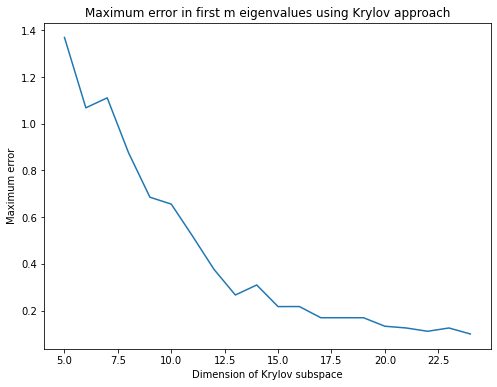

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(8,6))
ax.plot([i for i in range(m,25)],y)
ax.set_xlabel('Dimension of Krylov subspace')
ax.set_ylabel('Maximum error')
ax.set_title('Maximum error in first m eigenvalues using Krylov approach')
fig.show()

### Eigenvectors comparison

To compare first eigenvector computed with build-in method and other methods I calculate the $L2$ norm of the difference.

In [ ]:
power_diff = np.linalg.norm(power_eigenspace[:,::-1][:,0:m]-eigenspace[:,::-1][:,0:m],axis=0)
print('The L-2 norm of the difference between first eigenvector compute with build-in method and power method is', power_diff[0])

The L-2 norm of the difference between first eigenvector compute with build-in method and power method is 1.4165058427631485


In [ ]:
krylov_diff = np.linalg.norm(krilov_eigenspace[:,::-1][:,0:m]-eigenspace[:,::-1][:,0:m],axis=0)
print('The L-2 norm of the difference between first eigenvector compute with build-in method and krylov method is', krylov_diff[0])

The L-2 norm of the difference between first eigenvector compute with build-in method and krylov method is 1.7945932026970797


----

# Section2 : where we apply our functions to a real dataset

Use the webpages 
http://yann.lecun.com/exdb/mnist/  
or    
https://www.kaggle.com/c/digit-recognizer/data?select=train.csv   
to download the MNIST dataset. **We only need the training dataset.**   
This dataset consists of 28x28 = 784 pixel images which are your datapoints, and each of these images has a label 0,1,...,9 which corresponds to number that image represents. 

We want to compute accuracy, precsion and recall of the unsupervised clustering algorithm obtained by spectral embedding + kmeans on this data.

Unlike the previous section, you should:
1. Use only built-in eigenvector solvers here
2. Use built-in k-nearest-neighbor functions to create the adjacency matrix of the graph. For example the function `sklearn.neighbors.kneighbors_graph` in python works very well (and you can use this also in Julia via PyCall). 
3. Do not use the whole dataset from the beginning, it is very large and any error in the code can result in a huge loss in your time. Subsample the data by selecting m random points from each of the classes, with $m=100$, first, then $m=500$. When you are confident that everything is working, run it on the whole data. 
4. Try the clustering algorithm with two choices of k-nearest-neighbors = 7 and 15


## Apply same code as before

In this subsection I apply the same code as before, it works until 1000 data then it needs some improvements that are done in the next subsection.


### Function preamble

In [ ]:
# Import data
def import_data(dim):
  f = open('train.csv')
  dati = []
  for riga in f.readlines()[1:dim+1]:
    dati.append(np.array([int(i) for i in riga.split(',')]))
  f.close() 

  label_dati = np.array(dati) # transform in numpy array
  dati = label_dati[:,1:]     # data
  label = label_dati[:,0]     # label
  return dati,label
 

In [ ]:
def f(A,x):
    # Compute moltiplication between matrix and vector
    b = np.dot(A,x)
    return b

### Import data

First I decide to apply my previous code, without build-in eigenvectors function, to first 500 data.

In [ ]:
dim = 500    # dataset dimension
dati,label = import_data(dim)

### Initialization

In [ ]:
# Initialization
knn = 15
A = adjacency_knn_matrix(dati,knn, mode="binary") # adjacency matrix
L = normalized_Laplacian(A)
k = 10                                            # Number of classes we know the data is made of 
M = 2*np.identity(dim)-L

### k-means

In [ ]:
# k-means
loss_vec, c_dist, centroids = k_means_full(dati, k) # Apply k-means to the new dataset embedding
index = compute_classes(dati,centroids) # compute classes

Plot loss function and centroid distance function histories

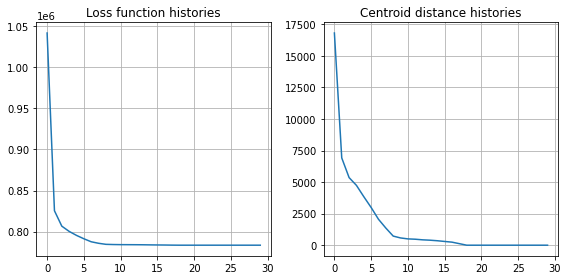

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].plot(loss_vec)
axs[0].set_title('Loss function histories')
axs[1].plot(c_dist)
axs[1].set_title('Centroid distance histories')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(index,label)

order(cm)
# Compute the accuracy of the class assignment
acc,prec,rec = validation_metrics(cm)
print('Accuracy:', acc, '\nRecall:', rec, '\nPrecision:', prec)
# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.482 
Recall: 0.4784363354201003 
Precision: 0.48339687575006873


,0,1,2,3,4,5,6,7,8,9
0,49,3,5,1,7,3,1,0,2,6
1,1,25,3,1,15,8,3,3,3,0
2,0,0,30,1,1,1,0,2,0,25
3,0,2,0,25,1,0,19,0,7,2
4,0,0,0,0,0,0,0,20,0,0
5,0,5,0,0,16,26,0,10,0,0
6,0,4,5,20,1,0,8,0,6,1
7,0,0,0,0,0,0,1,21,0,0
8,0,2,1,6,1,3,21,0,29,1
9,0,0,2,0,0,7,0,0,0,28


The algorithm works pretty well, it is able to divide properly half of the data. \\
It is interesting to note that can happens the case in which some numbers are almost never assign correctly. 

### Power method

In [ ]:
# power method
eigenvalues, eigenspace = first_m_eigvectors_power_method(f, k, dim, M) # Compute eigenvalues and eigenspace

loss_vec, c_dist, centroids = k_means_full(eigenspace, k) # Apply k-means to the new dataset embedding 
index = compute_classes(eigenspace,centroids) # compute classes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Plot loss function and centroid distance function histories

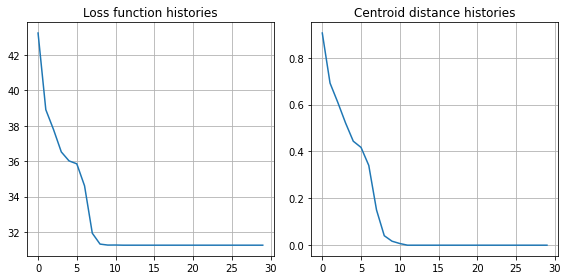

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].plot(loss_vec)
axs[0].set_title('Loss function histories')
axs[1].plot(c_dist)
axs[1].set_title('Centroid distance histories')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(index,label)
order(cm)
# Compute the accuracy of the class assignment
acc,prec,rec = validation_metrics(cm)
print('Accuracy:', acc, '\nRecall:', rec, '\nPrecision:', prec)
# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.488 
Recall: 0.5109943686303045 
Precision: 0.4808302234489988


,0,1,2,3,4,5,6,7,8,9
0,27,0,0,0,0,0,5,6,0,0
1,0,6,0,0,4,1,1,2,20,0
2,0,0,0,24,0,0,0,1,0,0
3,0,4,0,25,3,0,2,0,0,0
4,0,0,1,0,26,1,0,0,0,0
5,0,25,17,5,9,44,1,1,0,0
6,2,2,0,1,0,0,33,0,0,0
7,20,2,13,1,2,0,0,23,0,14
8,0,1,7,0,16,0,4,1,30,3
9,5,2,3,0,3,2,0,19,0,30


Also in this case results are quite good.  To notice that there are some numbers which are almost never assign correctly.



## Improved code



In this case matrix are saved as sparse matrix and I use only built-in eigenvector solvers. \\
In that way I am able to use all dataset.

In [ ]:
# function to compute sparse matrix M 
def compute_M(A,dim,knn):
  diag_vec= np.power(A.sum(axis=1),-0.5)    
  invroot_D = sp.sparse.diags(np.array(diag_vec.T)[0])
  L= sp.sparse.csc_matrix(np.identity(dim)-invroot_D@A@invroot_D)
  M = sp.sparse.csc_matrix(2*np.identity(dim)-L)
  return M

### Import data

In [ ]:
dim = 9000   # dataset dimension
dati,label = import_data(dim)

### Initialization

In [ ]:
knn = 15                          # k-nearest-neighbors
A = kneighbors_graph(dati,knn)
A = A.maximum(sp.sparse.csr_matrix.transpose(A))
k = 10                            # Number of classes we know the data is made of 
M = compute_M(A,dim,knn)

### Spectral embedding

To compute eigenvalues and eigenvectors I use built-in eigenvector solvers.

In [ ]:
eigval, eigenvec = sp.sparse.linalg.eigsh(M,k=10)

I decide to use one run k-means because I notice that k-means with $n$ restarts takes more time and produces results with a lower accuracy.

In [ ]:
# Select k points at random 
starting_centroids = select_k_points_from(k,eigenvec)

# Apply k-means to the new dataset embedding 
loss_vec, c_dist, centroids = k_means_one_run(eigenvec, starting_centroids)
index = compute_classes(eigenvec,centroids) # compute classes

In [ ]:
# Evaluate confusion matrix
cm = metrics.confusion_matrix(index,label)
order(cm)
# Compute the accuracy of the class assignment
acc,prec,rec = validation_metrics(cm)
print('Accuracy:', acc, '\nRecall:', rec, '\nPrecision:', prec)
# Show the confusion matrix
pd.DataFrame(cm)

Accuracy: 0.5947777777777777 
Recall: 0.5977131047609267 
Precision: 0.587803881816202


,0,1,2,3,4,5,6,7,8,9
0,0,0,0,1,0,0,3,293,0,1
1,0,805,2,0,0,6,0,0,2,1
2,4,24,535,7,11,4,0,6,18,7
3,4,13,446,4,3,4,0,0,13,11
4,11,12,0,444,518,12,1,3,67,6
5,463,26,3,14,0,851,17,3,3,331
6,3,7,0,4,0,0,848,9,0,6
7,8,1,2,1,1,2,19,569,0,1
8,1,17,1,17,0,5,0,0,740,2
9,320,32,4,409,347,16,11,9,92,483


Considering the method that we are using we achieve very good results: accuracy, recall and precision are about 70%. \\
In the case $knn=7$ results are a bit worst, near 60%.